In [ ]:
# Start writing code here...from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
spotify_songs = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv')


Q1 = np.percentile(spotify_songs.duration_ms, 25,
                   interpolation = 'midpoint')
Q3 = np.percentile(spotify_songs.duration_ms, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

"""
mask = (spotify_songs.duration_ms < (Q3+1.5*IQR))
mask2 = spotify_songs.duration_ms > (Q1-1.5*IQR)
spotify_data_cleaned = spotify_songs.loc[mask]
spotify_data_cleaned = spotify_data_cleaned.loc[mask2]
"""
spotify_data_cleaned = spotify_songs
spotify_data_cleaned.track_album_release_date.str[:4]
spotify_data_cleaned.track_album_release_date.str[5:7]
spotify_data_cleaned = spotify_data_cleaned.assign(
    track_album_release_month = spotify_data_cleaned.track_album_release_date.str[5:7],
    track_album_release_year = spotify_data_cleaned.track_album_release_date.str[:4],
)
spotify_data_cleaned.drop(columns="track_album_release_date",inplace=True)
spotify_data_cleaned.track_album_release_year = spotify_data_cleaned.track_album_release_year.astype("int64")
"""
mask = (spotify_data_cleaned.track_popularity > 0)
spotify_data_cleaned = spotify_data_cleaned.loc[mask]
"""


C:\Users\louis\AppData\Local\Temp\ipykernel_31568\1980743519.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(spotify_songs.duration_ms, 25,
C:\Users\louis\AppData\Local\Temp\ipykernel_31568\1980743519.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(spotify_songs.duration_ms, 75,


'\nmask = (spotify_data_cleaned.track_popularity > 0)\nspotify_data_cleaned = spotify_data_cleaned.loc[mask]\n'

In [ ]:
spotify_data_cleaned

NameError: name 'spotify_data_cleaned' is not defined

In [ ]:
mask = (spotify_data_cleaned.track_popularity > 0)
spotify_data_cleaned = spotify_data_cleaned.loc[mask]


mask1 = spotify_data_cleaned.track_popularity <= 80
mask2 = spotify_data_cleaned.track_popularity <=60
mask3 = spotify_data_cleaned.track_popularity <=40
mask4 = spotify_data_cleaned.track_popularity <=20

spotify_data_cleaned["popularity_quali"] = "trèsPopulaire"
spotify_data_cleaned.loc[mask1,"popularity_quali"] = "bienPopulaire"
spotify_data_cleaned.loc[mask2,"popularity_quali"] = "moyennementPopulaire"
spotify_data_cleaned.loc[mask3,"popularity_quali"] = "bofPopulaire"
spotify_data_cleaned.loc[mask4,"popularity_quali"] = "pasPopulaire"


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalisation(data):
    columns = ["track_popularity","danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo", "duration_ms", "track_album_release_year"]
    data_norme = data[columns]
    scaler = MinMaxScaler(feature_range=(0,1))
    data_norme = pd.DataFrame(scaler.fit_transform(data_norme), columns=columns)
    return data_norme


## Exploration

**D'abord, visualisation de la fréquence du nombres de musiques (présentes dans les playlists) par artiste**

Note : on vire les 400 premieres valeurs pour y voir plus clair

Martin Garrix       153
Queen               133
The Chainsmokers    121
David Guetta        106
Drake                98
                   ... 
Massari               1
Twisted Illusion      1
Rockie Brown          1
Veio                  1
Mat Zo                1
Name: track_artist, Length: 10026, dtype: int64


Text(0.5, 0, 'number of songs')

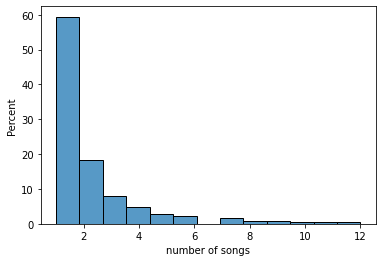

In [ ]:
artist_frequency = spotify_data_cleaned["track_artist"].value_counts()
print(artist_frequency)
sns.histplot(x=artist_frequency[400:],bins=13, stat="percent")
plt.xlabel("number of songs")


In [ ]:
for i in range(5):
    i=i+1
    sub_df = artist_frequency[artist_frequency == i ]
    print("Pourcentage d'artistes qui ont ",i, " chansons : ", sub_df.sum()/spotify_data_cleaned.shape[0]*100,"%")

sub_df = artist_frequency[artist_frequency <= 6 ]
print("Pourcentage artistes avec moins de 6 chansons : ", sub_df.sum()/spotify_data_cleaned.shape[0]*100,"%")

sub_df = artist_frequency[artist_frequency <= 17 ]
print("Pourcentage artistes avec moins de 17 chansons : ", sub_df.sum()/spotify_data_cleaned.shape[0]*100,"%")

#sns.boxplot( artist_frequency[artist_frequency < 10 ])

Pourcentage d'artistes qui ont  1  chansons :  18.99435778294059 %
Pourcentage d'artistes qui ont  2  chansons :  11.636242947228675 %
Pourcentage d'artistes qui ont  3  chansons :  7.517424493859941 %
Pourcentage d'artistes qui ont  4  chansons :  6.0006637902422835 %
Pourcentage d'artistes qui ont  5  chansons :  4.580152671755725 %
Pourcentage artistes avec moins de 6 chansons :  52.77132426153336 %
Pourcentage artistes avec moins de 17 chansons :  74.64985064719548 %


In [ ]:
np.median(artist_frequency)

1.0

On va partir sur le fait qu'avoir fait moins de 6 chansons signifie que l'artiste a peu de chansons et vice versa

In [ ]:
limite = 6 

## Test du chi2 indépendance entre popularité d'une chanson et le fait d'être un "gros" artiste

**On crée deux tableaux : un avec les petits artistes et un avec les gros artistes**

In [ ]:
index = artist_frequency[artist_frequency <= limite ].reset_index()["index"]
few_song_artist_name = []
for artist in index:
    few_song_artist_name.append(artist)
few_song_artist_name

['The Band CAMINO',
 'Wolfpack',
 'Anne-Marie',
 'Alizzmatic',
 'Dj Electrocimatic',
 'Diviners',
 'Cat Dealers',
 'COIN',
 'The Aces',
 'Jory Boy',
 'Habstrakt',
 'Glenn Gatsby',
 'EDX',
 'The Bloody Beetroots',
 'The Human League',
 'Genesis',
 'The Psychedelic Furs',
 'Jacob Tillberg',
 'Hinder',
 'Caravan Palace',
 'Trevor Daniel',
 'The Smashing Pumpkins',
 'Jonny Joel',
 'Nickelback',
 'Fetty Wap',
 'Brothers Page',
 'Lou Reed',
 'Santana',
 'Ericé',
 'DJ Mibor',
 'a-ha',
 'Dirty South',
 'Slipknot',
 'Interpol',
 'Ludvigsson',
 'Greeicy',
 'Pop Evil',
 'Roberto Marín Muñoz',
 'FLETCHER',
 'Skillet',
 'Petit Biscuit',
 'Los Angeles Azules',
 'MGMT',
 'Theory of a Deadman',
 'Silvestre Dangond',
 'Hellberg',
 'Foxa',
 'Phos Toni',
 'VIZE',
 'Lil Jon',
 'Pedro Capó',
 'Ralph Tresvant',
 'Cinderella',
 'Jody Watley',
 'Bad Gyal',
 'bülow',
 'Terror Jr',
 'Placebo',
 'Coolio',
 'Tainy',
 'Deniz Koyu',
 'Triomphe',
 'Blondie',
 'Starship',
 'FISHER',
 'Disclosure',
 'Gary Moore',
 'LM

In [ ]:
index = artist_frequency[artist_frequency > limite ].reset_index()["index"]
many_song_artist_name = []
for artist in index:
    many_song_artist_name.append(artist)
many_song_artist_name

['Martin Garrix',
 'Queen',
 'The Chainsmokers',
 'David Guetta',
 'Drake',
 'Don Omar',
 'Calvin Harris',
 'Hardwell',
 'Kygo',
 'Dimitri Vegas & Like Mike',
 "Guns N' Roses",
 'The Weeknd',
 'Avicii',
 'J Balvin',
 'Maroon 5',
 'Ed Sheeran',
 'Logic',
 'Major Lazer',
 'Bad Bunny',
 'Daddy Yankee',
 'Post Malone',
 'Khalid',
 'DJ Snake',
 'Ozuna',
 '2Pac',
 'Tiësto',
 'Rihanna',
 'Ariana Grande',
 'Zedd',
 'オメガトライブ',
 'Shawn Mendes',
 'Armin van Buuren',
 'Wisin & Yandel',
 'Selena Gomez',
 'Nicky Jam',
 'Coldplay',
 'Katy Perry',
 'Alan Walker',
 'Marshmello',
 'R3HAB',
 'Scorpions',
 'The Notorious B.I.G.',
 'Future',
 'The Cranberries',
 'Young Thug',
 'Sam Feldt',
 'Van Halen',
 'Steve Aoki',
 'Billie Eilish',
 'Gloria Estefan',
 'Jonas Blue',
 'Eminem',
 'Tyga',
 'Imagine Dragons',
 'OutKast',
 'Frank Ocean',
 '50 Cent',
 'Halsey',
 'Camila Cabello',
 'Cypress Hill',
 'Galantis',
 'Sia',
 'Aerosmith',
 'Janet Jackson',
 'Snoop Dogg',
 'Lil Wayne',
 'The Game',
 'The Who',
 'Led Z

In [ ]:
data_artist = spotify_data_cleaned

In [ ]:

for artist in few_song_artist_name:
    mask = data_artist["track_artist"] == artist
    data_artist.loc[mask,"has_a_big_repertoire"] = 0

for artist in many_song_artist_name:
    mask = data_artist["track_artist"] == artist
    data_artist.loc[mask,"has_a_big_repertoire"] = 1


In [ ]:
mask_many = data_artist.has_a_big_repertoire == 1
many_songs_artist = data_artist[mask_many]
mask_few = data_artist.has_a_big_repertoire == 0
few_songs_artist = data_artist[mask_few]


In [ ]:
popularity_few = few_songs_artist["popularity_quali"].value_counts()
popularity_many = many_songs_artist["popularity_quali"].value_counts()
print(popularity_few)
print(popularity_many)

moyennementPopulaire    5946
bofPopulaire            4668
bienPopulaire           2733
pasPopulaire            2446
trèsPopulaire            107
Name: popularity_quali, dtype: int64
bienPopulaire           4869
moyennementPopulaire    3771
pasPopulaire            2280
bofPopulaire            2077
trèsPopulaire           1233
Name: popularity_quali, dtype: int64


In [ ]:
"""popularity_few = few_songs_artist["playlist_genre"].value_counts()
popularity_many = many_songs_artist["playlist_genre"].value_counts()
print(popularity_few)
print(popularity_many)"""

'popularity_few = few_songs_artist["playlist_genre"].value_counts()\npopularity_many = many_songs_artist["playlist_genre"].value_counts()\nprint(popularity_few)\nprint(popularity_many)'

**On peut maintenant faire le test du chi2 sur la proportion des données selon la popularité et le fait d'être un gros artiste**

In [ ]:
#pip install spicy

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
cont = np.array(
    [popularity_few,
    popularity_many]
)
cont

array([[5946, 4668, 2733, 2446,  107],
       [4869, 3771, 2280, 2077, 1233]], dtype=int64)

In [ ]:
"""cont = np.array(
    [[5,9,6],
    [10,20,10],
    [0,1,9],
    [5,20,5],    
    ]
)"""
#https://www.deschamps.io/236-realiser-un-test-dindependance-chi2-en-python-avec-scipy-stats


'cont = np.array(\n    [[5,9,6],\n    [10,20,10],\n    [0,1,9],\n    [5,20,5],    \n    ]\n)'

In [ ]:
"""cont = np.array(
    [
    [50,70,110,60],
    [60,75,100,50],    
    ]
)"""

'cont = np.array(\n    [\n    [50,70,110,60],\n    [60,75,100,50],    \n    ]\n)'

In [ ]:
st_chi2, st_p, st_dof, st_exp = chi2_contingency(cont)


In [ ]:
print(st_chi2,st_dof,"\n",st_p)

1130.723069523791 4 
 1.6584367867068548e-243


In [ ]:
st_exp

array([[5707.21871888, 4453.37205443, 2645.42648523, 2386.84699635,
         707.1357451 ],
       [5107.78128112, 3985.62794557, 2367.57351477, 2136.15300365,
         632.8642549 ]])

p value très très proche de 0, on peut rejeuter l'hypothèse nulle : les variables ne sont pas indépendantes

<AxesSubplot:xlabel='playlist_genre', ylabel='count'>

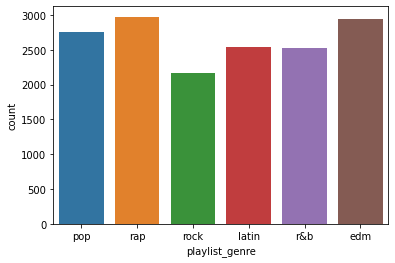

In [ ]:
sns.countplot(x=few_songs_artist.playlist_genre)

<AxesSubplot:xlabel='playlist_genre', ylabel='count'>

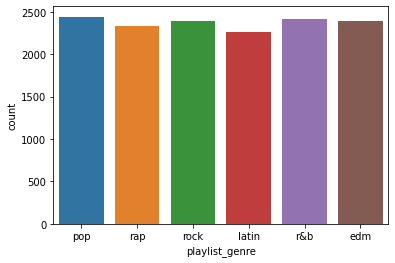

In [ ]:
sns.countplot(x=many_songs_artist.playlist_genre)

## Etude du nombre de genre par (gros) artiste

In [ ]:
TotalNbGenre = 0
NbArtist = 0
unSeulGenre = 0
for artist in many_song_artist_name:
   mask = data_artist["track_artist"] == artist
   data_by_artist = many_songs_artist[mask]
   count_genre_by_artist = data_by_artist["playlist_genre"].value_counts()
   TotalNbGenre += count_genre_by_artist.shape[0]
   NbArtist = NbArtist + 1
   if(count_genre_by_artist.shape[0]==1):
      unSeulGenre = unSeulGenre +1
print("Moyenne du nombre de genre par (gros) artiste: ", TotalNbGenre / NbArtist)
print("Nombre de gros artistes: ", NbArtist)
print("Nombre d'artiste ayant un seul genre :", unSeulGenre)

C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_by_artist = many_songs_artist[mask]
C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_by_artist = many_songs_artist[mask]
C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_by_artist = many_songs_artist[mask]
C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_by_artist = many_songs_artist[mask]
C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_by_artist = many_songs_artist[mask]
C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: Use

Moyenne du nombre de genre par (gros) artiste:  2.2465277777777777
Nombre de gros artistes:  864
Nombre d'artiste ayant un seul genre : 315


C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_by_artist = many_songs_artist[mask]
C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_by_artist = many_songs_artist[mask]
C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_by_artist = many_songs_artist[mask]
C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_by_artist = many_songs_artist[mask]
C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_by_artist = many_songs_artist[mask]
C:\Users\louis\AppData\Local\Temp\ipykernel_31568\3382671338.py:6: Use

Note : vérification que l'on ait bien une répartition 50-50 de musiques produites par un gros et un petit artiste

In [ ]:
few_songs_artist.shape[0]/spotify_data_cleaned.shape[0]

0.5277132426153336

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2ad4461-7f35-42f5-b2d9-f686e8952f67' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>